In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])

class NCarsImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

In [3]:
from torch.utils.data import DataLoader
data = NCarsImageDataset("./Datasety/CIFAR10-DVS_128_exp", transform=transforms)

generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=0.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=0.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x, inplace=False, min_val=0.0, max_val=1.0)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_CIFAR10-DVS_ReLU1_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug_corrected_exp.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_channels=6).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=0.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_s

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=0.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(

In [9]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=100,save_best=True, save_thr=48)

100%|██████████| 219/219 [01:04<00:00,  3.41it/s]


Epoch [1/100], Step [219/219], Loss: 2.9858, Accuracy: 0.1004
Accuracy of the network: 0.08366666666666667 Loss: 2.459725940481145


100%|██████████| 219/219 [01:06<00:00,  3.29it/s]


Epoch [2/100], Step [219/219], Loss: 2.3439, Accuracy: 0.1131
Accuracy of the network: 0.11333333333333333 Loss: 2.3261390188907054


100%|██████████| 219/219 [01:08<00:00,  3.19it/s]


Epoch [3/100], Step [219/219], Loss: 2.3345, Accuracy: 0.1093
Accuracy of the network: 0.11233333333333333 Loss: 2.3487296256613224


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [4/100], Step [219/219], Loss: 2.3196, Accuracy: 0.1131
Accuracy of the network: 0.099 Loss: 2.345172293642734


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [5/100], Step [219/219], Loss: 2.3387, Accuracy: 0.1104
Accuracy of the network: 0.10733333333333334 Loss: 2.3192226430203053


100%|██████████| 219/219 [01:11<00:00,  3.06it/s]


Epoch [6/100], Step [219/219], Loss: 2.2721, Accuracy: 0.1367
Accuracy of the network: 0.12766666666666668 Loss: 2.326129636865981


100%|██████████| 219/219 [01:10<00:00,  3.10it/s]


Epoch [7/100], Step [219/219], Loss: 2.2057, Accuracy: 0.1581
Accuracy of the network: 0.16866666666666666 Loss: 2.1669673323631287


100%|██████████| 219/219 [01:10<00:00,  3.11it/s]


Epoch [8/100], Step [219/219], Loss: 2.1634, Accuracy: 0.1703
Accuracy of the network: 0.168 Loss: 2.1577880864447736


100%|██████████| 219/219 [01:11<00:00,  3.05it/s]


Epoch [9/100], Step [219/219], Loss: 2.1389, Accuracy: 0.1630
Accuracy of the network: 0.19 Loss: 2.13383493651735


100%|██████████| 219/219 [01:07<00:00,  3.23it/s]


Epoch [10/100], Step [219/219], Loss: 2.1297, Accuracy: 0.1797
Accuracy of the network: 0.188 Loss: 2.1070104583780815


100%|██████████| 219/219 [01:10<00:00,  3.11it/s]


Epoch [11/100], Step [219/219], Loss: 2.1136, Accuracy: 0.1756
Accuracy of the network: 0.17933333333333334 Loss: 2.096272336675766


100%|██████████| 219/219 [01:08<00:00,  3.18it/s]


Epoch [12/100], Step [219/219], Loss: 2.1072, Accuracy: 0.1896
Accuracy of the network: 0.187 Loss: 2.0917369139955397


100%|██████████| 219/219 [01:06<00:00,  3.29it/s]


Epoch [13/100], Step [219/219], Loss: 2.0891, Accuracy: 0.1899
Accuracy of the network: 0.20866666666666667 Loss: 2.0807890968119844


100%|██████████| 219/219 [01:10<00:00,  3.09it/s]


Epoch [14/100], Step [219/219], Loss: 2.0849, Accuracy: 0.1971
Accuracy of the network: 0.20033333333333334 Loss: 2.0696050435938735


100%|██████████| 219/219 [01:09<00:00,  3.13it/s]


Epoch [15/100], Step [219/219], Loss: 2.0819, Accuracy: 0.1937
Accuracy of the network: 0.189 Loss: 2.072813110148653


100%|██████████| 219/219 [01:06<00:00,  3.29it/s]


Epoch [16/100], Step [219/219], Loss: 2.0551, Accuracy: 0.2111
Accuracy of the network: 0.221 Loss: 2.0750545757882137


100%|██████████| 219/219 [01:05<00:00,  3.32it/s]


Epoch [17/100], Step [219/219], Loss: 2.0369, Accuracy: 0.2227
Accuracy of the network: 0.22166666666666668 Loss: 2.052911230858336


100%|██████████| 219/219 [01:14<00:00,  2.92it/s]


Epoch [18/100], Step [219/219], Loss: 2.0071, Accuracy: 0.2376
Accuracy of the network: 0.22133333333333333 Loss: 2.0564015266743114


100%|██████████| 219/219 [01:08<00:00,  3.17it/s]


Epoch [19/100], Step [219/219], Loss: 1.9927, Accuracy: 0.2446
Accuracy of the network: 0.24133333333333334 Loss: 1.9843444951037144


100%|██████████| 219/219 [01:09<00:00,  3.17it/s]


Epoch [20/100], Step [219/219], Loss: 1.9478, Accuracy: 0.2607
Accuracy of the network: 0.27166666666666667 Loss: 1.9284947717443426


100%|██████████| 219/219 [01:06<00:00,  3.27it/s]


Epoch [21/100], Step [219/219], Loss: 1.9068, Accuracy: 0.2766
Accuracy of the network: 0.2776666666666667 Loss: 1.9181995937164793


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [22/100], Step [219/219], Loss: 1.8867, Accuracy: 0.2966
Accuracy of the network: 0.2956666666666667 Loss: 1.8937449391852035


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [23/100], Step [219/219], Loss: 1.8426, Accuracy: 0.3060
Accuracy of the network: 0.31966666666666665 Loss: 1.8178475410380261


100%|██████████| 219/219 [01:06<00:00,  3.29it/s]


Epoch [24/100], Step [219/219], Loss: 1.8228, Accuracy: 0.3214
Accuracy of the network: 0.31733333333333336 Loss: 1.8108907240502379


100%|██████████| 219/219 [01:06<00:00,  3.27it/s]


Epoch [25/100], Step [219/219], Loss: 1.7946, Accuracy: 0.3249
Accuracy of the network: 0.2906666666666667 Loss: 1.8486871668632994


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [26/100], Step [219/219], Loss: 1.7861, Accuracy: 0.3344
Accuracy of the network: 0.33366666666666667 Loss: 1.7901129468958428


100%|██████████| 219/219 [01:07<00:00,  3.24it/s]


Epoch [27/100], Step [219/219], Loss: 1.7724, Accuracy: 0.3410
Accuracy of the network: 0.3373333333333333 Loss: 1.7881881087384326


100%|██████████| 219/219 [01:08<00:00,  3.19it/s]


Epoch [28/100], Step [219/219], Loss: 1.7386, Accuracy: 0.3621
Accuracy of the network: 0.355 Loss: 1.7512872434676963


100%|██████████| 219/219 [01:09<00:00,  3.16it/s]


Epoch [29/100], Step [219/219], Loss: 1.7208, Accuracy: 0.3654
Accuracy of the network: 0.3526666666666667 Loss: 1.7447151947528758


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [30/100], Step [219/219], Loss: 1.7084, Accuracy: 0.3670
Accuracy of the network: 0.385 Loss: 1.7127524043651337


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [31/100], Step [219/219], Loss: 1.6903, Accuracy: 0.3767
Accuracy of the network: 0.38233333333333336 Loss: 1.7154836324935263


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [32/100], Step [219/219], Loss: 1.6632, Accuracy: 0.3863
Accuracy of the network: 0.38466666666666666 Loss: 1.6967720528866381


100%|██████████| 219/219 [01:07<00:00,  3.25it/s]


Epoch [33/100], Step [219/219], Loss: 1.6482, Accuracy: 0.3923
Accuracy of the network: 0.3883333333333333 Loss: 1.6742095706310678


100%|██████████| 219/219 [01:06<00:00,  3.30it/s]


Epoch [34/100], Step [219/219], Loss: 1.6145, Accuracy: 0.4069
Accuracy of the network: 0.39066666666666666 Loss: 1.6534194502424686


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [35/100], Step [219/219], Loss: 1.6014, Accuracy: 0.4233
Accuracy of the network: 0.4043333333333333 Loss: 1.6403167311181412


100%|██████████| 219/219 [01:07<00:00,  3.26it/s]


Epoch [36/100], Step [219/219], Loss: 1.5759, Accuracy: 0.4301
Accuracy of the network: 0.4066666666666667 Loss: 1.630536841585281


100%|██████████| 219/219 [01:07<00:00,  3.22it/s]


Epoch [37/100], Step [219/219], Loss: 1.5533, Accuracy: 0.4356
Accuracy of the network: 0.4226666666666667 Loss: 1.60517529350646


100%|██████████| 219/219 [01:09<00:00,  3.17it/s]


Epoch [38/100], Step [219/219], Loss: 1.5313, Accuracy: 0.4470
Accuracy of the network: 0.4236666666666667 Loss: 1.600020631830743


100%|██████████| 219/219 [01:05<00:00,  3.35it/s]


Epoch [39/100], Step [219/219], Loss: 1.5206, Accuracy: 0.4500
Accuracy of the network: 0.43433333333333335 Loss: 1.5936555190289274


100%|██████████| 219/219 [01:05<00:00,  3.35it/s]


Epoch [40/100], Step [219/219], Loss: 1.5001, Accuracy: 0.4576
Accuracy of the network: 0.42766666666666664 Loss: 1.588912748275919


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [41/100], Step [219/219], Loss: 1.4860, Accuracy: 0.4641
Accuracy of the network: 0.425 Loss: 1.5726910334952333


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [42/100], Step [219/219], Loss: 1.4696, Accuracy: 0.4707
Accuracy of the network: 0.451 Loss: 1.5457698943767142


100%|██████████| 219/219 [01:05<00:00,  3.36it/s]


Epoch [43/100], Step [219/219], Loss: 1.4463, Accuracy: 0.4864
Accuracy of the network: 0.44566666666666666 Loss: 1.545236180437372


100%|██████████| 219/219 [01:05<00:00,  3.35it/s]


Epoch [44/100], Step [219/219], Loss: 1.4300, Accuracy: 0.4926
Accuracy of the network: 0.45866666666666667 Loss: 1.5342017158548882


100%|██████████| 219/219 [01:05<00:00,  3.35it/s]


Epoch [45/100], Step [219/219], Loss: 1.4054, Accuracy: 0.4957
Accuracy of the network: 0.44966666666666666 Loss: 1.5387121350207227


100%|██████████| 219/219 [01:10<00:00,  3.11it/s]


Epoch [46/100], Step [219/219], Loss: 1.4049, Accuracy: 0.4939
Accuracy of the network: 0.453 Loss: 1.518981747170712


100%|██████████| 219/219 [01:09<00:00,  3.13it/s]


Epoch [47/100], Step [219/219], Loss: 1.4012, Accuracy: 0.5087
Accuracy of the network: 0.4483333333333333 Loss: 1.5261373659397692


100%|██████████| 219/219 [01:06<00:00,  3.28it/s]


Epoch [48/100], Step [219/219], Loss: 1.3619, Accuracy: 0.5186
Accuracy of the network: 0.4646666666666667 Loss: 1.506368249020678


100%|██████████| 219/219 [01:06<00:00,  3.31it/s]


Epoch [49/100], Step [219/219], Loss: 1.3686, Accuracy: 0.5100
Accuracy of the network: 0.472 Loss: 1.4972439218074718


100%|██████████| 219/219 [01:06<00:00,  3.31it/s]


Epoch [50/100], Step [219/219], Loss: 1.3456, Accuracy: 0.5224
Accuracy of the network: 0.47833333333333333 Loss: 1.470417191373541


100%|██████████| 219/219 [01:06<00:00,  3.31it/s]


Epoch [51/100], Step [219/219], Loss: 1.3308, Accuracy: 0.5287
Accuracy of the network: 0.468 Loss: 1.4915273569999856


100%|██████████| 219/219 [01:06<00:00,  3.31it/s]


Epoch [52/100], Step [219/219], Loss: 1.3272, Accuracy: 0.5299
Accuracy of the network: 0.49066666666666664 Loss: 1.4797370154806908


100%|██████████| 219/219 [01:06<00:00,  3.31it/s]


Epoch [53/100], Step [219/219], Loss: 1.3052, Accuracy: 0.5371
Accuracy of the network: 0.482 Loss: 1.474073273070315


100%|██████████| 219/219 [01:06<00:00,  3.31it/s]


Epoch [54/100], Step [219/219], Loss: 1.3068, Accuracy: 0.5336
Accuracy of the network: 0.4623333333333333 Loss: 1.486614020580941


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [55/100], Step [219/219], Loss: 1.2915, Accuracy: 0.5424
Accuracy of the network: 0.4836666666666667 Loss: 1.4745881481373564


100%|██████████| 219/219 [01:06<00:00,  3.31it/s]


Epoch [56/100], Step [219/219], Loss: 1.2876, Accuracy: 0.5424
Accuracy of the network: 0.471 Loss: 1.4755645185074908


100%|██████████| 219/219 [01:05<00:00,  3.32it/s]


Epoch [57/100], Step [219/219], Loss: 1.2719, Accuracy: 0.5497
Accuracy of the network: 0.47533333333333333 Loss: 1.456040789472296


100%|██████████| 219/219 [01:06<00:00,  3.31it/s]


Epoch [58/100], Step [219/219], Loss: 1.2740, Accuracy: 0.5514
Accuracy of the network: 0.4836666666666667 Loss: 1.458101918088629


100%|██████████| 219/219 [01:06<00:00,  3.31it/s]


Epoch [59/100], Step [219/219], Loss: 1.2647, Accuracy: 0.5546
Accuracy of the network: 0.4876666666666667 Loss: 1.447678933752344


100%|██████████| 219/219 [01:08<00:00,  3.22it/s]


Epoch [60/100], Step [219/219], Loss: 1.2502, Accuracy: 0.5533
Accuracy of the network: 0.491 Loss: 1.456034836616922


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [61/100], Step [219/219], Loss: 1.2392, Accuracy: 0.5609
Accuracy of the network: 0.48 Loss: 1.455147773661512


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [62/100], Step [219/219], Loss: 1.2522, Accuracy: 0.5583
Accuracy of the network: 0.4776666666666667 Loss: 1.4511280795361132


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [63/100], Step [219/219], Loss: 1.2423, Accuracy: 0.5593
Accuracy of the network: 0.492 Loss: 1.44339760060006


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [64/100], Step [219/219], Loss: 1.2366, Accuracy: 0.5627
Accuracy of the network: 0.486 Loss: 1.4528527310554018


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [65/100], Step [219/219], Loss: 1.2432, Accuracy: 0.5651
Accuracy of the network: 0.49133333333333334 Loss: 1.4366350852428598


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [66/100], Step [219/219], Loss: 1.2326, Accuracy: 0.5661
Accuracy of the network: 0.49466666666666664 Loss: 1.4337904066481488


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [67/100], Step [219/219], Loss: 1.2373, Accuracy: 0.5663
Accuracy of the network: 0.4876666666666667 Loss: 1.4442034769565502


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [68/100], Step [219/219], Loss: 1.2240, Accuracy: 0.5709
Accuracy of the network: 0.49766666666666665 Loss: 1.4299101759778692


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [69/100], Step [219/219], Loss: 1.2230, Accuracy: 0.5653
Accuracy of the network: 0.5003333333333333 Loss: 1.4318955191906462


100%|██████████| 219/219 [01:06<00:00,  3.32it/s]


Epoch [70/100], Step [219/219], Loss: 1.2177, Accuracy: 0.5746
Accuracy of the network: 0.501 Loss: 1.4304304275106876


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [71/100], Step [219/219], Loss: 1.2176, Accuracy: 0.5693
Accuracy of the network: 0.502 Loss: 1.4233814655466284


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [72/100], Step [219/219], Loss: 1.2063, Accuracy: 0.5694
Accuracy of the network: 0.49333333333333335 Loss: 1.4259796167941803


100%|██████████| 219/219 [01:05<00:00,  3.32it/s]


Epoch [73/100], Step [219/219], Loss: 1.2069, Accuracy: 0.5743
Accuracy of the network: 0.49533333333333335 Loss: 1.428725114528169


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [74/100], Step [219/219], Loss: 1.2149, Accuracy: 0.5680
Accuracy of the network: 0.49866666666666665 Loss: 1.4247173248453344


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [75/100], Step [219/219], Loss: 1.2143, Accuracy: 0.5701
Accuracy of the network: 0.49366666666666664 Loss: 1.412707988252031


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [76/100], Step [219/219], Loss: 1.2059, Accuracy: 0.5701
Accuracy of the network: 0.5003333333333333 Loss: 1.4259747894520456


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [77/100], Step [219/219], Loss: 1.2078, Accuracy: 0.5760
Accuracy of the network: 0.49666666666666665 Loss: 1.4312944107867303


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [78/100], Step [219/219], Loss: 1.1925, Accuracy: 0.5803
Accuracy of the network: 0.499 Loss: 1.4341196988491303


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [79/100], Step [219/219], Loss: 1.2007, Accuracy: 0.5790
Accuracy of the network: 0.508 Loss: 1.4316764366119465


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [80/100], Step [219/219], Loss: 1.1916, Accuracy: 0.5749
Accuracy of the network: 0.49866666666666665 Loss: 1.4333604333248544


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [81/100], Step [219/219], Loss: 1.2047, Accuracy: 0.5729
Accuracy of the network: 0.49666666666666665 Loss: 1.4321898101492132


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [82/100], Step [219/219], Loss: 1.2057, Accuracy: 0.5721
Accuracy of the network: 0.5063333333333333 Loss: 1.4112630435760984


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [83/100], Step [219/219], Loss: 1.1955, Accuracy: 0.5771
Accuracy of the network: 0.49966666666666665 Loss: 1.4310901177690385


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [84/100], Step [219/219], Loss: 1.1997, Accuracy: 0.5750
Accuracy of the network: 0.49266666666666664 Loss: 1.4257624599527805


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [85/100], Step [219/219], Loss: 1.1981, Accuracy: 0.5789
Accuracy of the network: 0.49966666666666665 Loss: 1.4350620089693273


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [86/100], Step [219/219], Loss: 1.1949, Accuracy: 0.5796
Accuracy of the network: 0.5053333333333333 Loss: 1.4264707590671295


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [87/100], Step [219/219], Loss: 1.1993, Accuracy: 0.5796
Accuracy of the network: 0.499 Loss: 1.4342264101860371


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [88/100], Step [219/219], Loss: 1.1954, Accuracy: 0.5756
Accuracy of the network: 0.499 Loss: 1.42317503817538


100%|██████████| 219/219 [01:05<00:00,  3.35it/s]


Epoch [89/100], Step [219/219], Loss: 1.2022, Accuracy: 0.5729
Accuracy of the network: 0.5073333333333333 Loss: 1.4188862645879705


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [90/100], Step [219/219], Loss: 1.1863, Accuracy: 0.5807
Accuracy of the network: 0.505 Loss: 1.4171724205321454


100%|██████████| 219/219 [01:05<00:00,  3.32it/s]


Epoch [91/100], Step [219/219], Loss: 1.1911, Accuracy: 0.5823
Accuracy of the network: 0.496 Loss: 1.413135326923208


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [92/100], Step [219/219], Loss: 1.1990, Accuracy: 0.5799
Accuracy of the network: 0.501 Loss: 1.42913774163165


100%|██████████| 219/219 [01:05<00:00,  3.32it/s]


Epoch [93/100], Step [219/219], Loss: 1.1963, Accuracy: 0.5740
Accuracy of the network: 0.5003333333333333 Loss: 1.4229922656049119


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [94/100], Step [219/219], Loss: 1.1887, Accuracy: 0.5744
Accuracy of the network: 0.499 Loss: 1.425021581193234


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [95/100], Step [219/219], Loss: 1.2040, Accuracy: 0.5731
Accuracy of the network: 0.504 Loss: 1.4261881404734673


100%|██████████| 219/219 [01:05<00:00,  3.33it/s]


Epoch [96/100], Step [219/219], Loss: 1.1910, Accuracy: 0.5743
Accuracy of the network: 0.495 Loss: 1.4407235954670197


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [97/100], Step [219/219], Loss: 1.1879, Accuracy: 0.5796
Accuracy of the network: 0.5033333333333333 Loss: 1.4184611883569271


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [98/100], Step [219/219], Loss: 1.1981, Accuracy: 0.5777
Accuracy of the network: 0.5073333333333333 Loss: 1.4187608139312013


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [99/100], Step [219/219], Loss: 1.1930, Accuracy: 0.5779
Accuracy of the network: 0.49933333333333335 Loss: 1.4123988107163856


100%|██████████| 219/219 [01:05<00:00,  3.34it/s]


Epoch [100/100], Step [219/219], Loss: 1.1977, Accuracy: 0.5776
Accuracy of the network: 0.49033333333333334 Loss: 1.433681772744402


In [10]:
torch.save(model, "best_resnet50_CIFAR10-DVS_ReLU1_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_exp.pt")

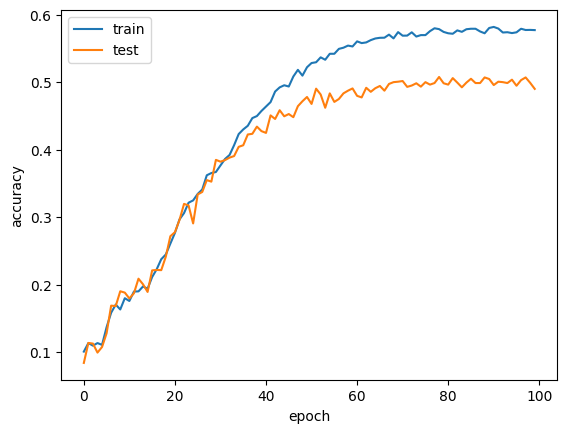

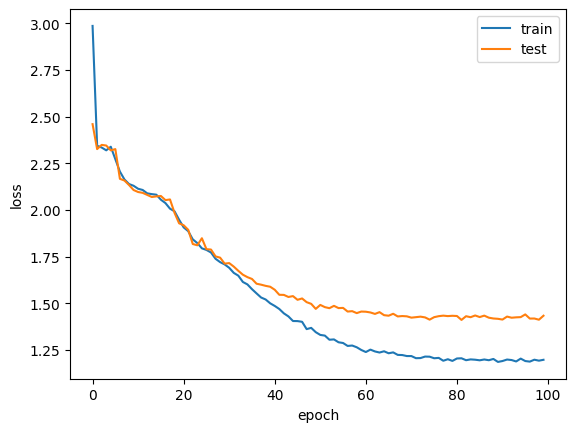

In [11]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [12]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet_CIFAR10-DVS_ReLU1_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_exp.csv')

In [13]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.100429,0.083667,2.985818,2.459726
1,0.113143,0.113333,2.343882,2.326139
2,0.109286,0.112333,2.334469,2.348730
3,0.113143,0.099000,2.319551,2.345172
4,0.110429,0.107333,2.338708,2.319223
